In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import List, Tuple, Dict, Union, Any, Optional
from tqdm import tqdm
import json
try:
    os.chdir(os.path.join(os.getcwd(), '../../Language-Technology-Project'))
    print(os.getcwd())
except:
    print("ALready in current dir")

c:\Users\mo\Documents\Organisations\RUG\Language-Technology-Project


In [2]:
from modules.cmv.data import read_data, write_data, format_data, show_data

# Read the data
data = read_data(path= "./datasets/threads_light.jsonl")
data = format_data(data)
show_data(data)

Head: CMV: I don't believe there is any good reason to ever feel angry about anything. I don't think it can ever help you even a little bit.
 Comment 0: When I was little, my dad would deliberately make ...

Head: I Believe Junior Soldiers Are Grossly Overpaid
 Comment 0: Your submission has been automatically removed bec...

Head: I think they should "cultivate" a more laid back culture here cmv
 Comment 0: The problem is less strict subreddits run into pro...
 Comment 1: I'm subbed to r/braveryjerk; I'm quite aware of wh...

Head: CMV: Toronto is the best city in North America
 Comment 0: Hey i live in toronto... it's definitely not the b...
 Comment 1: &gt;  I'd give that to either SF (where I've lived...
 Comment 2: &gt; I actually think Toronto has better weather!
...
 ...

Head: CMV: Students get more out of standard-level courses than they do out of AP courses.
 Comment 0: If your teachers focus on "teaching the test" as m...
 Comment 1: I suppose? My issue is that the curriculu

In [17]:
from modules.hv_net import HVClassifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the model
model = HVClassifier()
model = model.load("./models/hv_net.pt")
model = model.to(device)

In [21]:
def dummy_embedder(text: List[str]) -> np.ndarray:
    """
    Dummy embedder
    Args:
        text: list of strings
    Returns:
        embeddings: list of lists
    """
    embeddings = []
    for i in range(len(text)):
        emebdding = np.random.rand(16)
        embeddings.append(emebdding)
    embeddings = np.array(embeddings)
    return embeddings

def embedder(text: List[str]) -> np.ndarray:
    x = model.predict(text, return_type="np")
    # x = np.where(x >= 0.75, 1, 0)
    return x

def compute_agreement_summary(entry: dict, dist_func, embdedder=dummy_embedder):
    # compute the agreement summary
    summary = {
        "agreement_score": None,
        "distances": None
    }

    # Compute emebddings
    head_embedding = embdedder([entry["head"]])[0]
    comment_embeddings = embdedder(entry["comments"])
    head_embeddings = np.repeat(head_embedding.reshape(1, -1), comment_embeddings.shape[0], axis=0)
    distances = dist_func(comment_embeddings, head_embeddings)

    summary["distances"] = distances
    summary["agreement_score"] = np.mean(distances)

    return summary

def compute_agreement_summaries(data: List[dict], dist_func=lambda x, y: np.prod(x*y, axis=1), embedder=dummy_embedder):
    """
    Compute the agreement summaries for all posts
    Args:
        data: list of dictionaries
        dist_func: distance function
    Returns:
        summary: dictionary 
    """
    summaries = []
    for entry in tqdm(data):
        summary = compute_agreement_summary(entry, dist_func, embedder)
        summaries.append(summary)
    return summaries

cosine_sim = lambda x, y: np.sum(x*y, axis=1) / (np.linalg.norm(x, axis=1) * np.linalg.norm(y, axis=1))
summaries = compute_agreement_summaries(data, embedder=embedder, dist_func=cosine_sim)
summaries[:3]


100%|██████████| 1024/1024 [00:36<00:00, 28.09it/s]


[{'agreement_score': 0.0050789197,
  'distances': array([0.00507892], dtype=float32)},
 {'agreement_score': 0.06508952,
  'distances': array([0.06508952], dtype=float32)},
 {'agreement_score': 0.08188494,
  'distances': array([0.06474484, 0.09902505], dtype=float32)}]

In [22]:
mu = np.mean([len(entry["comments"]) for entry in data])
sigma = np.std([len(entry["comments"]) for entry in data])
per = np.percentile([len(entry["comments"]) for entry in data], [0, 25, 50, 75, 100])
max_len = np.max([len(entry["comments"]) for entry in data])
min_len = np.min([len(entry["comments"]) for entry in data])

print(f"Mean: {mu}, Std: {sigma}, Percentiles: {per}, sample size: {len(data)}, max: {max_len}, min: {min_len}")

Mean: 4.447265625, Std: 8.837683008611101, Percentiles: [  1.   1.   1.   4. 102.], sample size: 1024, max: 102, min: 1


Sample agreement score: 0.12631361186504364


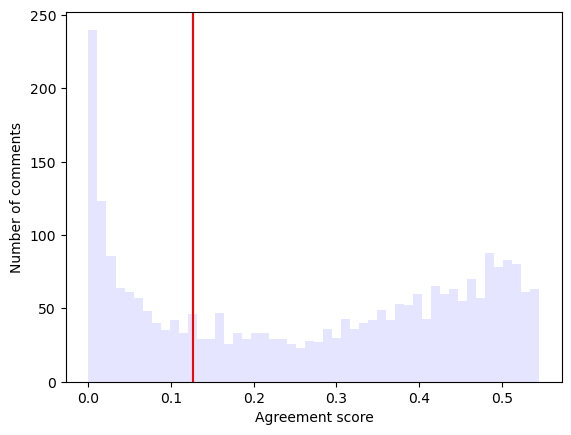

In [77]:

all_distances =  np.concatenate([entry["distances"] for entry in summaries])
all_distances_mean = np.mean(all_distances)
all_distances_std = np.std(all_distances)
all_distances_interval = -1.96 * all_distances_std, 1.96 * all_distances_std

sample = np.random.choice(summaries)
sample_agreement = sample["agreement_score"]
print(f"Sample agreement score: {sample_agreement}")

# Values are smaller than 1e-4
plt.hist(all_distances, range=(0, all_distances_interval[1]), bins=50, label="All distances", alpha=0.1, color="blue")

plt.axvline(x=sample_agreement, color="red", label="Sample agreement score")

plt.xlabel("Agreement score")
plt.ylabel("Number of comments")
plt.show()

In [78]:
def embed_posts(data: list[dict], embedder):

    results = []
    for entry in tqdm(data):
        head_embedding = embedder([entry["head"]])[0]
        comment_embeddings = embedder(entry["comments"])
        results.append({
            "head": head_embedding,
            "comments": comment_embeddings
        })
    return results

embedded_posts = embed_posts(data, embedder=embedder)

100%|██████████| 1024/1024 [00:38<00:00, 26.88it/s]


In [97]:
dist_func = cosine_sim

comment_head_comparisons = []
commment_comment_comparisons = []

for entry in tqdm(embedded_posts):
    head = entry["head"]
    comments = entry["comments"]
    repeated_head = np.repeat(head.reshape(1, -1), comments.shape[0], axis=0)
    comment_head_comparisons += list(dist_func(comments, repeated_head))

    # Take 100 random other posts
    random_posts = np.random.choice(embedded_posts, size=100, replace=False)
    for random_post in random_posts:
        random_post_comments = random_post["comments"]
        for comment in comments:
            repeated_comment = np.repeat(comment.reshape(1, -1), random_post_comments.shape[0], axis=0)
            commment_comment_comparisons += list(dist_func(random_post_comments, repeated_comment))


100%|██████████| 1024/1024 [00:04<00:00, 213.43it/s]


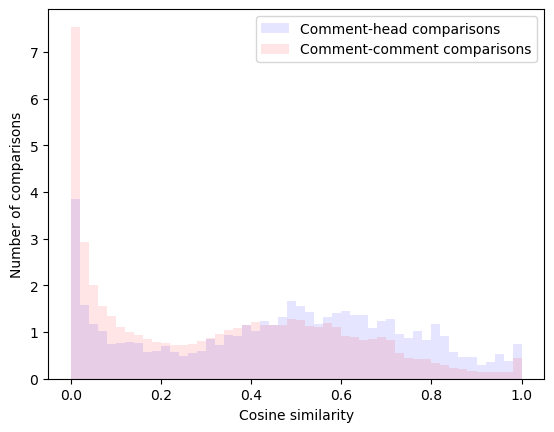

In [101]:

# Normalize frequencies to go only from 0 to 1
plt.hist(comment_head_comparisons, range=(0, 1), bins=50, label="Comment-head comparisons", alpha=0.1, color="blue", density=True)
plt.hist(commment_comment_comparisons, range=(0, 1), bins=50, label="Comment-comment comparisons", alpha=0.1, color="red", density=True)

plt.xlabel("Cosine similarity")
plt.ylabel("Number of comparisons")
plt.legend()
plt.show()